In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from tmv_app.tasks import get_coherence, get_exclusivity

### DTM runs

In [9]:
method="BD"
search_id = 63
run_qs =  RunStats.objects.filter(psearch__id=search_id, method=method, status=3)
run_ids = [run_id[0] for run_id in run_qs.values_list('run_id')]
print(run_ids)

[1914, 1901, 1900, 1923, 1899, 1904, 1907, 1915, 1917, 1916, 1913, 1905, 1906, 1903, 1902, 1898]


In [10]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).coherence:
        print("Calculating coherence for run {}".format(run_id))
        get_coherence(run_id)

In [11]:
for run_id in run_ids:
    if not RunStats.objects.get(run_id=run_id).exclusivity:
        print("Calculating exclusivity for run {}".format(run_id))
        get_exclusivity(run_id)

In [13]:
from django_pandas.io import read_frame
# https://github.com/chrisdev/django-pandas/

run_df = read_frame(RunStats.objects.filter(psearch__id=search_id, method=method, status=3),
                    #index_col='run_id',
                    fieldnames=['run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'])

# alternatively:
# run_df = pd.DataFrame.from_dict(RunStats.objects.filter(psearch__id=search_id, method=method).values('run_id','coherence','exclusivity'))

#run_df.set_index('run_id')
run_df = run_df.sort_values('run_id').set_index('run_id')
run_df

,coherence,exclusivity,K,alpha,top_chain_var,rng_seed,max_iter
run_id,,,,,,,
1898,0.436897,0.496150,20,0.010,0.005,1,50
1899,0.468952,0.653998,30,0.010,0.005,1,50
1900,0.482651,0.702931,40,0.010,0.005,1,50
1901,0.479601,0.690050,30,0.005,0.005,1,200
1902,0.485324,0.679939,30,0.020,0.005,1,200
1903,0.449967,0.676139,30,0.010,0.010,1,200
1904,0.526911,0.470431,30,0.010,0.001,1,200
1905,0.471405,0.661080,30,0.010,0.005,1,200
1906,0.460576,0.587462,25,0.010,0.005,1,50


<IPython.core.display.Javascript object>


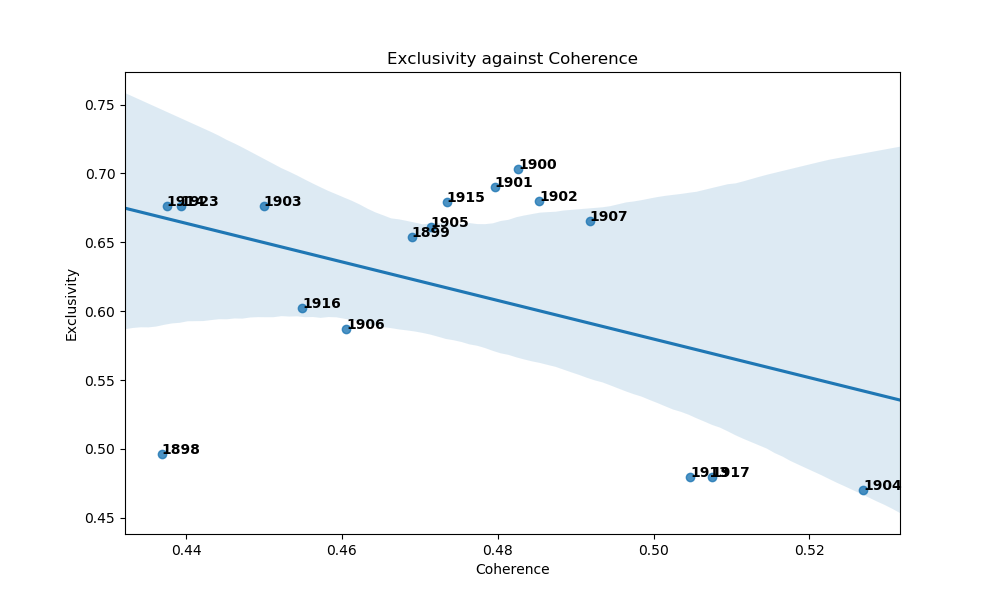

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [14]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
p = sns.regplot(x='coherence', y='exclusivity', data=run_df, ax = ax)

for run_id in run_df.index:
    p.text(run_df.coherence[run_id], run_df.exclusivity[run_id],
           run_id, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Coherence",ylabel="Exclusivity", title="Exclusivity against Coherence")

In [15]:
# measure concentration in the distribution of topics

def gini(x):
    # from https://pysal.readthedocs.io/en/latest/_modules/pysal/inequality/gini.html#Gini
    # see also: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    n = len(x)
    try:
        x_sum = x.sum()
    except AttributeError:
        x = np.asarray(x)
        x_sum = x.sum()
    n_x_sum = n * x_sum
    r_x = (2. * np.arange(1, len(x)+1) * x[np.argsort(x)]).sum()
    return (r_x - n_x_sum - x_sum) / n_x_sum


def gini_array(x, axis=0):
    try:
        n = x.shape[axis]
    except AttributeError:
        x = np.asarray(x)
        n = x.shape[axis]
    m = x.shape[(axis + 1) % 2]
    x_sum = x.sum(axis=axis)
    n_x_sum = n * x_sum
    r_x = np.zeros(m)
    for i in range(m):
        if axis == 1:
            y = x[i]
        else:
            y = x.T[i]
        r_x[i] = (2. * np.arange(1, n + 1) * y[np.argsort(y)]).sum()

        if (r_x[i] - n_x_sum[i] - x_sum[i]) == 0 and n_x_sum[i] == 0:
            n_x_sum[i] = 1

    return (r_x - n_x_sum - x_sum) / n_x_sum

def robin_hood(x):
    """
    Calculate the robin hood (or Hoover) index
    """
    try:
        mean = x.mean()
    except AttributeError:
        x = np.asarray(x)
        mean = x.mean()
    
    return np.abs(x - mean).sum() / (2 * x.sum())

In [21]:
data = []
for run_id in run_ids:
    ts = np.array([score[0] for score in Topic.objects.filter(run_id=run_id).values_list('score')])
    run_df.append([run_id, gini(ts), robin_hood(ts)])
    data.append({'run_id': run_id, 'gini': gini(ts), 'robin_hood': robin_hood(ts)})
ineq_df = pd.DataFrame(data)

In [22]:
ineq_df = ineq_df.sort_values('run_id').set_index('run_id')
df = run_df.join(ineq_df)
df

,coherence,exclusivity,K,alpha,top_chain_var,rng_seed,max_iter,gini,robin_hood
run_id,,,,,,,,,
1898,0.436897,0.496150,20,0.010,0.005,1,50,0.368422,0.257181
1899,0.468952,0.653998,30,0.010,0.005,1,50,0.399618,0.282848
1900,0.482651,0.702931,40,0.010,0.005,1,50,0.452214,0.326824
1901,0.479601,0.690050,30,0.005,0.005,1,200,0.347331,0.241736
1902,0.485324,0.679939,30,0.020,0.005,1,200,0.373071,0.269803
1903,0.449967,0.676139,30,0.010,0.010,1,200,0.296883,0.209190
1904,0.526911,0.470431,30,0.010,0.001,1,200,0.616680,0.483859
1905,0.471405,0.661080,30,0.010,0.005,1,200,0.367438,0.267132
1906,0.460576,0.587462,25,0.010,0.005,1,50,0.385014,0.272751


<IPython.core.display.Javascript object>


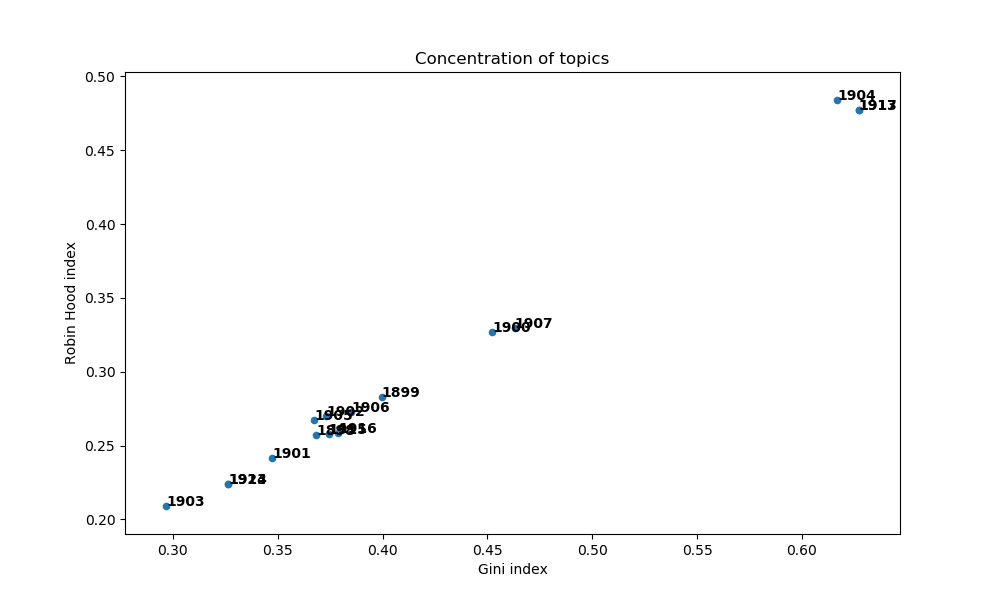

In [23]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
p = df.plot.scatter(x='gini', y='robin_hood', ax=ax)

for run_id in df.index:
    p.text(df.gini[run_id], df.robin_hood[run_id],
           run_id, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Gini index",ylabel="Robin Hood index", title="Concentration of topics")

<IPython.core.display.Javascript object>


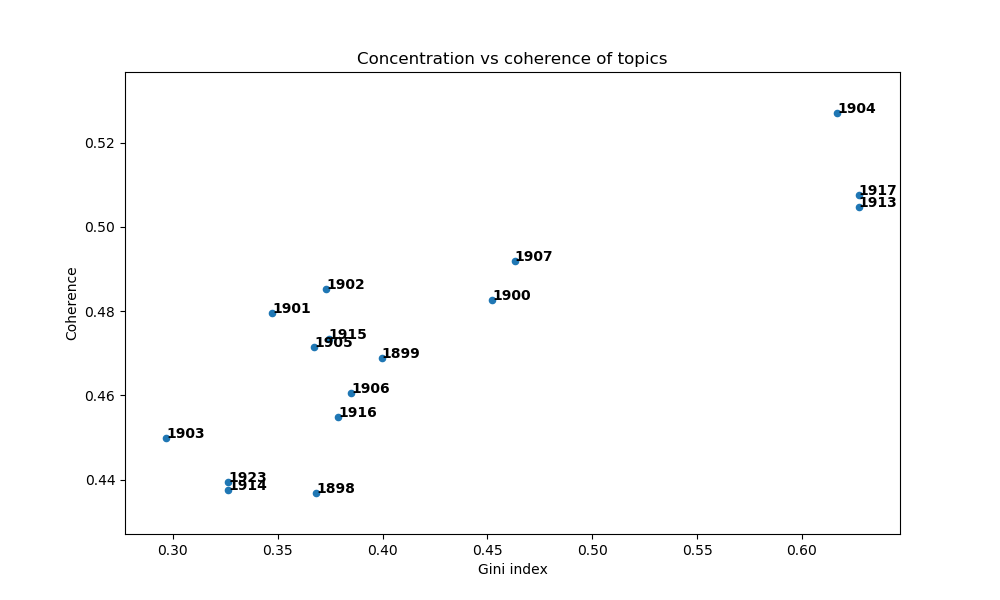

In [29]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,6))
p = df.plot.scatter(x='gini', y='coherence', ax=ax)

for run_id in df.index:
    p.text(df.gini[run_id], df.coherence[run_id],
           run_id, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set(xlabel="Gini index",ylabel="Coherence", title="Concentration vs coherence of topics")

<IPython.core.display.Javascript object>


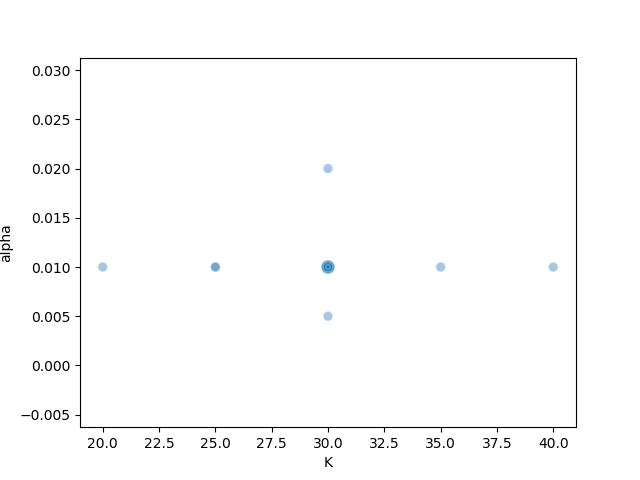

In [43]:
%matplotlib notebook

plt.scatter(x = df.K, 
            y = df.alpha, 
            s = df.top_chain_var*10000,
            alpha=0.4,
            edgecolors='w')

plt.xlabel('K')
plt.ylabel('alpha')

<IPython.core.display.Javascript object>


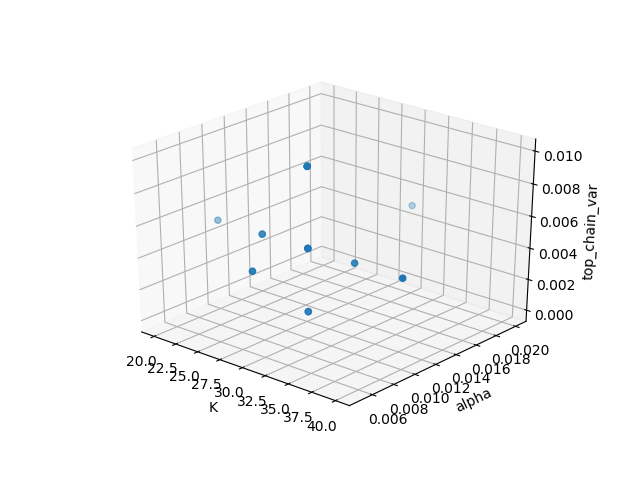

In [32]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')

threedee.scatter(df.K, df.alpha, df.top_chain_var)
threedee.set_xlabel('K')
threedee.set_ylabel('alpha')
threedee.set_zlabel('top_chain_var')